In [ ]:
import pandas as pd
import numpy as np
import ast

# Cargar el dataset fusionado que usaste para el particionado
test_df = pd.read_csv('../data/final_merged_dataset.csv')

# Reconvertir las columnas si se exportaron como strings
import re

def parse_genres_vector(raw):
    if isinstance(raw, str):
        # Reemplazamos espacios por comas si no hay ya comas
        if ',' not in raw:
            raw = re.sub(r'\s+', ',', raw.strip())
        try:
            return np.array(ast.literal_eval(raw), dtype=np.float32)
        except Exception as e:
            print(f"Error al parsear: {raw}")
            raise e
    return np.zeros(20, dtype=np.float32)  # fallback

test_df['genres_vector'] = test_df['genres_vector'].apply(parse_genres_vector)

def parse_tag_features(x, dim=32):
    if isinstance(x, str):
        try:
            return np.array(ast.literal_eval(x), dtype=np.float32)
        except Exception:
            pass
    # Si es NaN o ha fallado el parseo
    return np.zeros(dim, dtype=np.float32)

test_df['tag_features'] = test_df['tag_features'].apply(parse_tag_features)


# Convertir las columnas de índices y rating
test_user = torch.tensor(test_df['userIndex'].values, dtype=torch.long)
test_movie = torch.tensor(test_df['movieIndex'].values, dtype=torch.long)
test_rating = torch.tensor(test_df['rating_norm'].values, dtype=torch.float32)

# Convertir features
test_movie_features = torch.tensor(np.stack(test_df['genres_vector'].values), dtype=torch.float32)
test_tag_features = torch.tensor(np.stack(test_df['tag_features'].values), dtype=torch.float32)

from torch.utils.data import Dataset, DataLoader

# Dataset para modelos sin tags
class MovieLensDataset(Dataset):
    def __init__(self, users, movies, ratings, movie_features):
        self.users = users
        self.movies = movies
        self.ratings = ratings
        self.movie_features = movie_features
    def __len__(self):
        return len(self.ratings)
    def __getitem__(self, idx):
        return {
            'user': self.users[idx],
            'movie': self.movies[idx],
            'rating': self.ratings[idx],
            'movie_features': self.movie_features[idx]
        }

# Dataset para el modelo que requiere tags
class MovieLensDatasetWithTags(Dataset):
    def __init__(self, users, movies, ratings, movie_features, tag_features):
        self.users = users
        self.movies = movies
        self.ratings = ratings
        self.movie_features = movie_features
        self.tag_features = tag_features
    def __len__(self):
        return len(self.ratings)
    def __getitem__(self, idx):
        return {
            'user': self.users[idx],
            'movie': self.movies[idx],
            'rating': self.ratings[idx],
            'movie_features': self.movie_features[idx],
            'tag_features': self.tag_features[idx]
        }

batch_size = 512

# DataLoader para modelos sin tags (Modelos 1 y 2)
test_dataset = MovieLensDataset(test_user, test_movie, test_rating, test_movie_features)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# DataLoader para el modelo con tags (Modelo 3)
test_dataset_tags = MovieLensDatasetWithTags(test_user, test_movie, test_rating, test_movie_features, test_tag_features)
test_loader_tags = DataLoader(test_dataset_tags, batch_size=batch_size)


In [9]:
import torch.nn as nn

# Asumimos que usaste estos valores
embedding_dim = 64
num_genres = 20
tag_input_dim = 32

# Calculamos automáticamente el número de usuarios y películas
num_users = int(test_df['userIndex'].max() + 1)
num_movies = int(test_df['movieIndex'].max() + 1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Modelo 1: Solo ratings
class NCFOnlyRatings(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, user, movie):
        u = self.user_embedding(user)
        m = self.movie_embedding(movie)
        x = torch.cat([u, m], dim=1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        return self.output_layer(x).squeeze()

model_only = NCFOnlyRatings(num_users, num_movies, embedding_dim).to(device)
model_only.load_state_dict(torch.load("../models/solo_rantings.pth", map_location=device))
print("Modelo 1 (solo ratings) cargado.")

# Modelo 2: Ratings + genres
class NCFMovies(nn.Module):
    def __init__(self, num_users, num_movies, genre_input_dim, embedding_dim):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.genre_layer = nn.Linear(genre_input_dim, 32)
        self.fc1 = nn.Linear(embedding_dim * 2 + 32, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, user, movie, movie_features):
        u = self.user_embedding(user)
        m = self.movie_embedding(movie)
        g = torch.relu(self.genre_layer(movie_features))
        x = torch.cat([u, m, g], dim=1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        return self.output_layer(x).squeeze()

model_movies = NCFMovies(num_users, num_movies, num_genres, embedding_dim).to(device)
model_movies.load_state_dict(torch.load("../models/movies_ratings.pth", map_location=device))
print("Modelo 2 (ratings + genres) cargado.")

# Modelo 3: Ratings + genres + tags
class NCFMoviesTags(nn.Module):
    def __init__(self, num_users, num_movies, genre_input_dim, tag_input_dim, embedding_dim):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.genre_layer = nn.Linear(genre_input_dim, 32)
        self.tag_layer = nn.Linear(tag_input_dim, 16)
        self.fc1 = nn.Linear(embedding_dim * 2 + 32 + 16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, user, movie, movie_features, tag_features):
        u = self.user_embedding(user)
        m = self.movie_embedding(movie)
        g = torch.relu(self.genre_layer(movie_features))
        t = torch.relu(self.tag_layer(tag_features))
        x = torch.cat([u, m, g, t], dim=1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        return self.output_layer(x).squeeze()

model_tags = NCFMoviesTags(num_users, num_movies, num_genres, tag_input_dim, embedding_dim).to(device)
model_tags.load_state_dict(torch.load("../models/ratings_movies_tags.pth", map_location=device))
print("Modelo 3 (ratings + genres + tags) cargado.")

Modelo 1 (solo ratings) cargado.
Modelo 2 (ratings + genres) cargado.
Modelo 3 (ratings + genres + tags) cargado.


In [14]:
from sklearn.metrics import r2_score
from collections import defaultdict
import numpy as np

def evaluate_model(model, data_loader, device, with_tags=False, k=10):
    model.eval()
    all_preds = []
    all_truth = []
    user_preds = defaultdict(list)
    user_truth = defaultdict(list)

    with torch.no_grad():
        for batch in data_loader:
            users = batch['user'].to(device)
            movies = batch['movie'].to(device)
            ratings = batch['rating'].to(device)
            movie_features = batch['movie_features'].to(device)

            if with_tags:
                tag_features = batch['tag_features'].to(device)
                preds = model(users, movies, movie_features, tag_features)
            else:
                preds = model(users, movies, movie_features)

            # Desnormalizar: escala original de 0 a 5
            preds = (preds * 5).cpu().numpy()
            truths = (ratings * 5).cpu().numpy()

            all_preds.extend(preds)
            all_truth.extend(truths)

            for u, p, t in zip(users.cpu().numpy(), preds, truths):
                user_preds[u].append(p)
                user_truth[u].append(t)

    all_preds = np.array(all_preds)
    all_truth = np.array(all_truth)

    rmse = np.sqrt(np.mean((all_preds - all_truth) ** 2))
    mae = np.mean(np.abs(all_preds - all_truth))
    r2 = r2_score(all_truth, all_preds)

    precisions = []
    recalls = []
    ndcgs = []

    def ndcg_at_k(relevances, k):
        relevances = np.asarray(relevances)[:k]
        if relevances.size == 0:
            return 0.0
        dcg = np.sum((2 ** relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))
        ideal_relevances = np.sort(relevances)[::-1]
        idcg = np.sum((2 ** ideal_relevances - 1) / np.log2(np.arange(2, ideal_relevances.size + 2)))
        return dcg / idcg if idcg > 0 else 0.0

    for u in user_preds:
        preds_u = np.array(user_preds[u])
        truths_u = np.array(user_truth[u])

        top_k_idx = np.argsort(-preds_u)[:k]
        relevant = (truths_u >= 4.0).astype(int)

        precision = np.sum(relevant[top_k_idx]) / k
        recall = np.sum(relevant[top_k_idx]) / np.sum(relevant) if np.sum(relevant) > 0 else 0.0
        ndcg = ndcg_at_k(relevant[top_k_idx], k)

        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)

    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Precision@K': np.mean(precisions),
        'Recall@K': np.mean(recalls),
        'NDCG@K': np.mean(ndcgs)
    }

In [16]:
# Modelo 1: solo user y movie
def evaluate_model_only(model, data_loader, device, k=10):
    model.eval()
    all_preds = []
    all_truth = []
    user_preds = defaultdict(list)
    user_truth = defaultdict(list)

    with torch.no_grad():
        for batch in data_loader:
            users = batch['user'].to(device)
            movies = batch['movie'].to(device)
            ratings = batch['rating'].to(device)
            preds = model(users, movies)
            preds = (preds * 5).cpu().numpy()
            truths = (ratings * 5).cpu().numpy()

            all_preds.extend(preds)
            all_truth.extend(truths)
            for u, p, t in zip(users.cpu().numpy(), preds, truths):
                user_preds[u].append(p)
                user_truth[u].append(t)

    all_preds = np.array(all_preds)
    all_truth = np.array(all_truth)

    rmse = np.sqrt(np.mean((all_preds - all_truth) ** 2))
    mae = np.mean(np.abs(all_preds - all_truth))
    r2 = r2_score(all_truth, all_preds)

    precisions, recalls, ndcgs = [], [], []

    for u in user_preds:
        preds_u = np.array(user_preds[u])
        truths_u = np.array(user_truth[u])
        top_k_idx = np.argsort(-preds_u)[:k]
        relevant = (truths_u >= 4.0).astype(int)

        precision = np.sum(relevant[top_k_idx]) / k
        recall = np.sum(relevant[top_k_idx]) / np.sum(relevant) if np.sum(relevant) > 0 else 0.0
        def dcg(relevances):
            return np.sum((2 ** relevances - 1) / np.log2(np.arange(2, 2 + len(relevances))))

        relevances_k = relevant[top_k_idx]
        ideal_relevances_k = np.sort(relevant)[::-1][:k]

        ndcg = dcg(relevances_k) / (dcg(ideal_relevances_k) + 1e-10)


        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)

    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Precision@K': np.mean(precisions),
        'Recall@K': np.mean(recalls),
        'NDCG@K': np.mean(ndcgs)
    }

In [17]:
results_only = evaluate_model_only(model_only, test_loader, device)
print("✅ Modelo 1 evaluado.")

results_movies = evaluate_model(model_movies, test_loader, device, with_tags=False)
print("✅ Modelo 2 evaluado.")

results_tags = evaluate_model(model_tags, test_loader_tags, device, with_tags=True)
print("✅ Modelo 3 evaluado.")

✅ Modelo 1 evaluado.
✅ Modelo 2 evaluado.
✅ Modelo 3 evaluado.


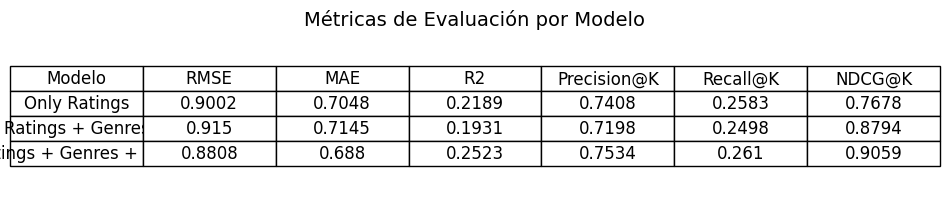

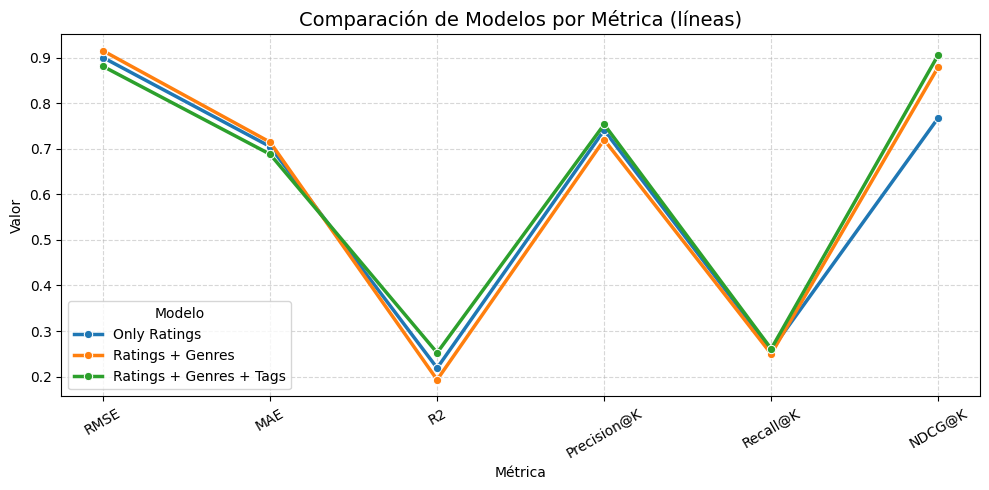

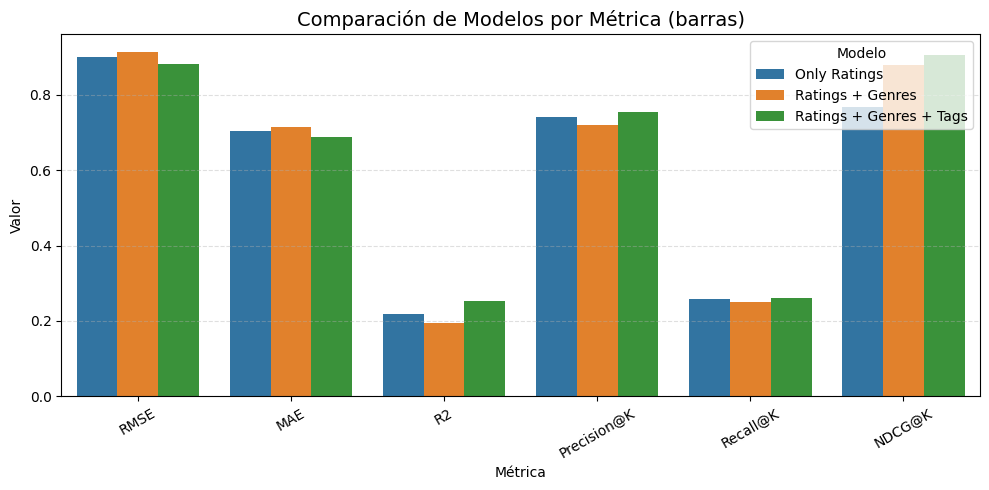

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Copia del dataframe y formateo
df = comparison_df.copy()
df = df.round(4)  # Redondeamos para mayor claridad
df.reset_index(inplace=True)
df.rename(columns={'index': 'Modelo'}, inplace=True)

# Tabla visual
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
plt.title("Métricas de Evaluación por Modelo", fontsize=14, pad=10)
plt.show()

# Gráfico de líneas por métrica
df_melted = df.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_melted, x='Métrica', y='Valor', hue='Modelo', marker='o', linewidth=2.5)
plt.title("Comparación de Modelos por Métrica (líneas)", fontsize=14)
plt.xticks(rotation=30)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Gráfico de barras agrupadas
plt.figure(figsize=(10, 5))
sns.barplot(data=df_melted, x='Métrica', y='Valor', hue='Modelo')
plt.title("Comparación de Modelos por Métrica (barras)", fontsize=14)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()